In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
import seaborn as sns
import statsmodels.api as sm
import numpy as np
from collections import defaultdict

In [91]:
#data_source = '../Money-Mavericks/data/data.csv'
data_source = './data/data.csv'
df = pd.read_csv(data_source)

years = ['2015', '2016', '2017', '2018', '2019']

jobgrowth = pd.DataFrame()

for yr in years:
    jg = pd.read_excel(f'./data/jobgrowth/{yr}-jobgrowth.xls', skiprows=[0, 1])
    jg['Year'] = yr
    jg = pd.concat([jg[['Year']], jg.drop(columns=['Year'])], axis=1)
    jobgrowth = pd.concat([jobgrowth, jg], ignore_index=True)

# Code to read in GDP data from state excel files.
# Virginia link: https://www.statista.com/statistics/188142/gdp-of-the-us-federal-state-of-virginia-since-1997/
gdp_va = pd.read_excel("./data/GDP/virginia-2000-2022.xlsx", sheet_name="Data", skiprows=4, usecols="B, C", names=['Year', 'GDP'])
income_va = pd.read_csv('./data/income/va-historic.csv')

# Code to read in Median Income data from FRED csv files. 
# Virginia link: https://fred.stlouisfed.org/series/MEHOINUSVAA672N

income_va_range = income_va.loc[income_va['DATE'].str.contains('|'.join(years))].reset_index().drop(columns=["index"])
income_va_range.head()


,DATE,Median Income
0,2015-01-01,70315
1,2016-01-01,75025
2,2017-01-01,78265
3,2018-01-01,83243
4,2019-01-01,86172


In [92]:
# X = df[["State", "Education Budget", "Unemployment Rate", "Population Estimate", "Year", "SNAPS cost"]]
X = df[['State','Education Budget','Unemployment Rate','Population Estimate','SNAPS household_participants',
        'SNAPS individual_participants','SNAPS cost','SNAPS cost_per_person','SNAPS cost_per_household','Year']]
# X.head()
data_by_state = defaultdict(pd.core.frame.DataFrame)
jg_by_state = defaultdict(pd.core.frame.DataFrame)
states = set()

# Loop over the rows of the employment data
for index, row in X.iterrows():
    state = row['State']
    states.add(state)
    data_by_state[state] = X[X['State'] == state].reset_index()

# Loop over the rows of the job growth data
for index, row in jobgrowth.iterrows():
    state = row['State']
    jg_by_state[state] = jobgrowth[jobgrowth['State'] == state].reset_index()


for state in states:
    # Concatenate the columns with the same years
    if state == 'District of Columbia':
        continue

    df_concat = pd.concat([data_by_state[state], jg_by_state[state][['U.S. Rank','% Change','Job Growth (In Thousands)','# of Jobs (In Thousands)']]], axis=1)
    df_concat = df_concat.drop(columns=['index'])
    # Add the concatenated data to the dictionary by state
    data_by_state[state] = df_concat
    

# Get GDP from 2015-2019 to add to Virginia's DF (Repeat for all states)
va_year_range = gdp_va.iloc[15:20][['GDP']].reset_index().drop(columns=['index'])
data_by_state['Virginia'] = pd.concat([data_by_state['Virginia'], va_year_range, income_va_range.drop(columns=['DATE'])], axis=1)


# unemployed = []
# snaps = []
# education = []

# # Poverty rate in virginia ~10.2%
# # Poverse population YoY is roughly 1:1 to the population increase YoY (e.g., 10.2% of new citizens are also poverse)?
# for index, row in data_by_state['Virginia'].iterrows():
#     unemp_pop = np.ceil(row['Population Estimate'] * (row['Unemployment Rate'] / 100))
#     edu_fund = row['Education Budget']
#     education.append(edu_fund)
#     unemployed.append(unemp_pop)
#     snap_house = row['SNAPS household_participants']
#     snaps.append(snap_house)

#     if index == 0:
#         print(f"Year: {row['Year']}\t Unemployed Population: {unemp_pop}\n\t\t Snap house: {snap_house}")
#         print(f"\t\tEducation Funding: {edu_fund}\n")
#         continue
    
#     snap_change = snaps[index-1] - snap_house
#     print(f"Year: {row['Year']}\t Unemployed Population: {unemp_pop} (Fewer unemployed: {unemployed[index-1] - unemp_pop})\n\t\t\tSnap house: {snap_house} (Fewer SNAP: {snaps[index-1] - snap_house})")
#     print(f"\t\t\tSNAPS Percent Change: {round((snap_change / snaps[index-1])*100, 2)}")
#     print(f"\t\tEducation Budget: {edu_fund} (Change from Last Year: {edu_fund - education[index-1]})\n")
    
    
data_by_state['Virginia'].head()

,State,Education Budget,Unemployment Rate,Population Estimate,SNAPS household_participants,SNAPS individual_participants,SNAPS cost,SNAPS cost_per_person,SNAPS cost_per_household,Year,U.S. Rank,% Change,Job Growth (In Thousands),# of Jobs (In Thousands),GDP,Median Income
0,Virginia,4.286211e+09,4.4,8361808,404347.5833,860374.7500,1230788073,253.657192,119.210467,2015,33.0,1.51,55.9,"3,766.70",455.16,70315
1,Virginia,4.352947e+09,4.1,8410106,387632.5833,826353.5833,1169412644,251.400575,117.929000,2016,16.0,2.24,84.4,"3,851.10",459.97,75025
2,Virginia,4.404296e+09,3.8,8463587,367230.5000,775548.0833,1115536652,253.141792,119.865408,2017,22.0,1.39,53.6,"3,904.70",467.36,78265
3,Virginia,4.526295e+09,3.0,8501286,352312.6667,736220.9167,1051800978,248.784925,119.054050,2018,21.0,1.32,51.5,"3,956.20",477.92,83243
4,Virginia,4.493670e+09,2.8,8535519,318522.0000,654882.0000,1002380166,262.250000,127.550000,2019,23.0,1.22,48.2,"4,004.40",489.20,86172


In [21]:
X = pd.get_dummies(data=X, drop_first=True)
print(X.shape)
print(X.head())

(251, 6)
          State  Education Budget  Unemployment Rate  Population Estimate  \
0  2.729781e+09               6.1            4852347         4.179434e+05   
1  4.152387e+08               6.5             737498         3.418733e+04   
2  6.241051e+09               6.1            6829676         4.393297e+05   
3  1.334963e+09               5.2            2978048         2.140558e+05   
4  1.672784e+10               6.2           38918045         2.096960e+06   

   Year  SNAPS cost  
0   NaN  267.561450  
1   NaN  409.641025  
2   NaN  276.858275  
3   NaN  252.570325  
4   NaN  299.164858  


In [50]:
y = df["SNAPS cost"]
print(y)

# If we have the states respective SNAPS participation for that year then we should/would be predicting all
# values for the next year (e.g., with past years figures we can predict with linear regression education budget, etc.)

0      1341906577
1       168054411
2      1459584642
3       648769562
4      7528039778
          ...    
246    1002380166
247    1192380309
248     397899950
249     778373061
250      36277115
Name: SNAPS cost, Length: 251, dtype: int64


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(200, 4)
(51, 4)
(200,)
(51,)


In [19]:
model = LinearRegression()
print(X_train, y_train)
model.fit(X_train,y_train)

     Education Budget  Unemployment Rate  Population Estimate  Year
55       2.724959e+09                3.3              5539215  2016
108      8.794744e+09                4.2             20963613  2017
104      1.708403e+10                4.8             39358497  2017
160      4.573090e+08                2.4              1420593  2018
39       2.202214e+09                6.0              4891938  2015
..                ...                ...                  ...   ...
63       3.654316e+09                4.4              6634304  2016
70       4.033029e+09                3.9              6823608  2016
81       1.120674e+10                4.8             19633428  2016
11       6.798729e+08                4.1              1651059  2015
95       4.352947e+09                4.1              8410106  2016

[200 rows x 4 columns] 55      728042703
108    4783367429
104    6732719405
160     469433045
39     1208604782
          ...    
63     1068458926
70     1189716303
81     492240643

LinearRegression()

In [8]:
print(model.intercept_)

52822728799.19895


In [41]:
# Predict what the SNAP funding will be for that year given their education budget, unemployment, and population
predictions = model.predict(X_test)
predDf = pd.DataFrame(predictions, columns=['SNAP Funding (Prediction)'])

# Mapping SNAP cost to test values
df = pd.DataFrame(np.column_stack([X_test, predictions]), columns=['Education budget', 'Unemployment', 'Population', 'Year', 'Snap (Prediction)'])
df.head()


,Education budget,Unemployment,Population,Year,Snap (Prediction)
0,4.473198e+09,3.9,10381615.0,2018.0,1.873046e+09
1,3.770574e+09,3.3,5639632.0,2019.0,9.911604e+08
2,2.448102e+09,4.4,6003323.0,2016.0,1.159691e+09
3,1.158363e+10,4.1,19530351.0,2018.0,3.805464e+09
4,3.503643e+09,4.1,8886025.0,2018.0,1.595833e+09


<Axes: xlabel='SNAPS cost'>

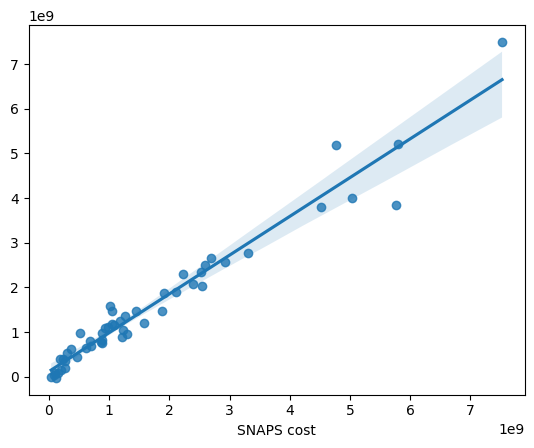

In [10]:
sns.regplot(x=y_test,y=predictions)

In [11]:
X_train_Sm= sm.add_constant(X_train)
ls=sm.OLS(y_train,X_train_Sm).fit()
print(ls.summary())

                            OLS Regression Results                            
Dep. Variable:             SNAPS cost   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     874.2
Date:                Tue, 18 Apr 2023   Prob (F-statistic):          2.79e-123
Time:                        12:18:57   Log-Likelihood:                -4196.4
No. Observations:                 200   AIC:                             8403.
Df Residuals:                     195   BIC:                             8419.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                5.282e+10   3